In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Load dataset
df = pd.read_csv('english_dataset.csv')
dfi = pd.read_csv('english_translated.csv')

dfi

,Tweet,Sentiment
0,Keep peace with one another MARK 9 : 50 .,positive
1,What counsel did Jesus give to help us handle ...,positive
2,What questions might a Christian ask himself w...,neutral
3,How can the threesteps outlined at Matthew 18 ...,positive
4,What human struggles are featured in Genesis,neutral
...,...,...
1974,[ 2 ] ( paragraph 3 ) See the box “ Reasons to...,Neutral
1975,There they hear the good news through public w...,Positive
1976,Left : The convent in Zaragoza,Neutral
1977,I did not know whether I was doing the right t...,Positive


In [3]:
dfi.head()
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      1979 non-null   object
 1   Sentiment  1979 non-null   object
dtypes: object(2)
memory usage: 31.0+ KB


In [4]:
import re
import nltk
from nltk.stem.cistem import Cistem
from nltk.stem import *
from nltk.stem.porter import *

from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.tokenize import TweetTokenizer 

tweet_tokenizer = TweetTokenizer()
stemmer_ENG = PorterStemmer()
stemmer_GER = Cistem()


LINKS = "http\S+"
USERNAMES = "@\S+"
CONSECUTIVE = '[.]{2,}'
NON_ALPHA = '(?:(?<=^)|(?<=\s))(\d+[.,]*)+(?=$|\s)'
HASHTAG = '#'
RT = 'rt'
SYMBOLS = '[^\w& ]+'



def tweet_to_words_ENG(text):
    text = text.lower() # Convert to lower case
    # text = expand(text) #expands contractions
    text = re.sub(LINKS, "XXXLINKXXX", text) # Replace links with token
    text = re.sub(USERNAMES, "XXXUSERNAMEXXX", text) # Replace mentions with token
    text = re.sub(CONSECUTIVE, ' ... ', text) # Unify consecutive periods
    text = re.sub(NON_ALPHA, "", text) # Remove all numbers not being part of alphanumeric word
    text = re.sub(HASHTAG, "", text) # Remove '#' in front of hashtags
    text = re.sub(RT, "", text) # Remove 'RT'
    text = re.sub(SYMBOLS, " ", text) # removes symbols
    text = text.lower()
 
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Feli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = df[['Tweet', 'Sentiment']]
pd.set_option('display.max_colwidth', None)

df['clean'] = df["Tweet"].apply(tweet_to_words_ENG)

maps = {-1: "negative", 0:"neutral", 1:"positive"}
df['Sentiment'] = df['Sentiment'].map(maps)
df

,Tweet,Sentiment,clean
0,@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that.,neutral,xxxusernamexxx xxxusernamexxx what do these 1 2 naked pics have to do with anything they re not even like that
1,OH: ‚ÄúI had a blue penis while I was this‚Äù [playing with Google Earth VR],neutral,oh äúi had a blue penis while i was this äù playing with google eah vr
2,"@user @user That's coming, but I think the victims are going to be Medicaid recipients.",neutral,xxxusernamexxx xxxusernamexxx that s coming but i think the victims are going to be medicaid recipients
3,I think I may be finally in with the in crowd #mannequinchallenge #grads2014 @user,positive,i think i may be finally in with the in crowd mannequinchallenge grads2014 xxxusernamexxx
4,"@user Wow,first Hugo Chavez and now Fidel Castro. Danny Glover, Michael Moore, Oliver Stone, and Sean Penn are running out of heroes.",negative,xxxusernamexxx wow first hugo chavez and now fidel castro danny glover michael moore oliver stone and sean penn are running out of heroes
...,...,...,...
12279,Sentinel Editorial: FBI‚Äôs Comey ‚Äòhad no one of middle class families.,neutral,sentinel editorial fbi äôs comey äòhad no one of middle class families
12280,perfect pussy clips #vanessa hudgens zac efron naked,neutral,perfect pussy clips vanessa hudgens zac efron naked
12281,#latestnews 4 #newmexico #politics + #nativeamerican + #Israel + #Palestine - Protesting Rise Of Alt-Right At...,neutral,latestnews newmexico politics nativeamerican israel palestine protesting rise of alt right at
12282,Trying to have a conversation with my dad about vegetarianism is the most pointless infuriating thing ever #caveman,negative,trying to have a conversation with my dad about vegetarianism is the most pointless infuriating thing ever caveman


In [6]:
df = pd.DataFrame(df)
dfi = pd.DataFrame(dfi)
df

,Tweet,Sentiment,clean
0,@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that.,neutral,xxxusernamexxx xxxusernamexxx what do these 1 2 naked pics have to do with anything they re not even like that
1,OH: ‚ÄúI had a blue penis while I was this‚Äù [playing with Google Earth VR],neutral,oh äúi had a blue penis while i was this äù playing with google eah vr
2,"@user @user That's coming, but I think the victims are going to be Medicaid recipients.",neutral,xxxusernamexxx xxxusernamexxx that s coming but i think the victims are going to be medicaid recipients
3,I think I may be finally in with the in crowd #mannequinchallenge #grads2014 @user,positive,i think i may be finally in with the in crowd mannequinchallenge grads2014 xxxusernamexxx
4,"@user Wow,first Hugo Chavez and now Fidel Castro. Danny Glover, Michael Moore, Oliver Stone, and Sean Penn are running out of heroes.",negative,xxxusernamexxx wow first hugo chavez and now fidel castro danny glover michael moore oliver stone and sean penn are running out of heroes
...,...,...,...
12279,Sentinel Editorial: FBI‚Äôs Comey ‚Äòhad no one of middle class families.,neutral,sentinel editorial fbi äôs comey äòhad no one of middle class families
12280,perfect pussy clips #vanessa hudgens zac efron naked,neutral,perfect pussy clips vanessa hudgens zac efron naked
12281,#latestnews 4 #newmexico #politics + #nativeamerican + #Israel + #Palestine - Protesting Rise Of Alt-Right At...,neutral,latestnews newmexico politics nativeamerican israel palestine protesting rise of alt right at
12282,Trying to have a conversation with my dad about vegetarianism is the most pointless infuriating thing ever #caveman,negative,trying to have a conversation with my dad about vegetarianism is the most pointless infuriating thing ever caveman


In [7]:
df['clean'] = df["Tweet"].apply(tweet_to_words_ENG)
# Assuming tweet_to_words_ENG is your cleaning function for English translations
# and tweet_to_words_PIDGIN is your cleaning function for Pidgin tweets
dfi['clean'] = dfi["Tweet"].apply(tweet_to_words_ENG)
dfi

,Tweet,Sentiment,clean
0,Keep peace with one another MARK 9 : 50 .,positive,keep peace with one another mark
1,What counsel did Jesus give to help us handle differences in a spirit of love ?,positive,what counsel did jesus give to help us handle differences in a spirit of love
2,What questions might a Christian ask himself when deciding how to settle differences with others ?,neutral,what questions might a christian ask himself when deciding how to settle differences with others
3,How can the threesteps outlined at Matthew 18 : 15 - 17 be used to resolve some conflicts ?,positive,how can the threesteps outlined at matthew be used to resolve some conflicts
4,What human struggles are featured in Genesis,neutral,what human struggles are featured in genesis
...,...,...,...
1974,[ 2 ] ( paragraph 3 ) See the box “ Reasons to Attend Meetings . ”,Neutral,paragraph see the box reasons to attend meetings
1975,There they hear the good news through public witnessing,Positive,there they hear the good news through public witnessing
1976,Left : The convent in Zaragoza,Neutral,left the convent in zaragoza
1977,I did not know whether I was doing the right thing .,Positive,i did not know whether i was doing the right thing


In [28]:
# Example of correcting an incorrect label
df['Sentiment'] = df['Sentiment'].replace('postive', 'positive') # if 'postive' was a typo
df

,Tweet,Sentiment,clean
0,we don realize hin importance after that city ...,positive,we don realize hin impoance after that city lo...
1,dem don nominate and second senator ovie omoag...,neutral,dem don nominate and second senator ovie omoag...
2,don come give una free awoof ...awoof!!! o .. ...,positive,don come give una free awoof awoof o s...
3,coronavirus update: washing your hands with so...,neutral,coronavirus update washing your hands with so...
4,"""people dey talk about iniesta paul scholes pu...",NaN,people dey talk about iniesta paul scholes pu...
...,...,...,...
13995,why america target iran general qasem soleimani.,neutral,why america target iran general qasem soleimani
13996,which of these be the most fierce managerial r...,positive,which of these be the most fierce managerial r...
13997,even tammy abraham know say marcus rashford na...,positive,even tammy abraham know say marcus rashford na...
13998,you strong o. some pipo blood pressure don cli...,positive,you strong o some pipo blood pressure don cli...


In [10]:
df = df.dropna(subset=['Sentiment'])
df

,Tweet,Sentiment,clean
0,@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that.,neutral,xxxusernamexxx xxxusernamexxx what do these 1 2 naked pics have to do with anything they re not even like that
1,OH: ‚ÄúI had a blue penis while I was this‚Äù [playing with Google Earth VR],neutral,oh äúi had a blue penis while i was this äù playing with google eah vr
2,"@user @user That's coming, but I think the victims are going to be Medicaid recipients.",neutral,xxxusernamexxx xxxusernamexxx that s coming but i think the victims are going to be medicaid recipients
3,I think I may be finally in with the in crowd #mannequinchallenge #grads2014 @user,positive,i think i may be finally in with the in crowd mannequinchallenge grads2014 xxxusernamexxx
4,"@user Wow,first Hugo Chavez and now Fidel Castro. Danny Glover, Michael Moore, Oliver Stone, and Sean Penn are running out of heroes.",negative,xxxusernamexxx wow first hugo chavez and now fidel castro danny glover michael moore oliver stone and sean penn are running out of heroes
...,...,...,...
12279,Sentinel Editorial: FBI‚Äôs Comey ‚Äòhad no one of middle class families.,neutral,sentinel editorial fbi äôs comey äòhad no one of middle class families
12280,perfect pussy clips #vanessa hudgens zac efron naked,neutral,perfect pussy clips vanessa hudgens zac efron naked
12281,#latestnews 4 #newmexico #politics + #nativeamerican + #Israel + #Palestine - Protesting Rise Of Alt-Right At...,neutral,latestnews newmexico politics nativeamerican israel palestine protesting rise of alt right at
12282,Trying to have a conversation with my dad about vegetarianism is the most pointless infuriating thing ever #caveman,negative,trying to have a conversation with my dad about vegetarianism is the most pointless infuriating thing ever caveman


# DATA SHAPING FOR MODEL INPUT

In [8]:
# # The maximum number of words to be used. (most frequent)
FREQUENT_WORDS_COUNT = 20000
# # Max number of words for the padding -> max length tweet 280 chars ~60 words, also best results after experimenting
SEQUENCE_LENGTH_COUNT =60
# Specify the dimension of each token's vector.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=FREQUENT_WORDS_COUNT, lower=True, oov_token="<OOV>")
# tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(dfi["Tweet"].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2531 unique tokens.


In [9]:
X = tokenizer.texts_to_sequences(dfi["Tweet"].values)
X = pad_sequences(X, maxlen=SEQUENCE_LENGTH_COUNT)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1979, 60)


In [10]:
shape =dfi['Sentiment'].values.shape
print(shape)

(1979,)


In [11]:
Y = pd.get_dummies(dfi['Sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1979, 6)


In [12]:
# Normalize the sentiment labels to lowercase
dfi['Sentiment'] = dfi['Sentiment'].str.lower()

# Apply one-hot encoding
Y = pd.get_dummies(dfi['Sentiment']).values

# Check the new shape of Y
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1979, 3)


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1781, 60) (1781, 3)
(198, 60) (198, 3)


# MODEL CREATION

In [14]:
ENG_LSTM_OOV = Sequential()
ENG_LSTM_OOV.add(Embedding(FREQUENT_WORDS_COUNT, EMBEDDING_DIM, input_length=X.shape[1]))
ENG_LSTM_OOV.add(SpatialDropout1D(0.2))
ENG_LSTM_OOV.add(LSTM(170, dropout=0.2))

# ENG_LSTM_OOV.add(Bidirectional(LSTM(100, dropout=0.2)))
ENG_LSTM_OOV.add(Dense(3, activation='softmax'))
ENG_LSTM_OOV.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(ENG_LSTM_OOV.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           2000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 170)               184280    
                                                                 
 dense (Dense)               (None, 3)                 513       
                                                                 
Total params: 2,184,793
Trainable params: 2,184,793
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
epochs = 3
batch_size = 64

history = ENG_LSTM_OOV.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/3
26/26 [==============================] - 8s 179ms/step - loss: 0.8804 - accuracy: 0.5949 - val_loss: 0.7772 - val_accuracy: 0.6704
Epoch 2/3
26/26 [==============================] - 4s 149ms/step - loss: 0.7393 - accuracy: 0.7047 - val_loss: 0.6998 - val_accuracy: 0.6983
Epoch 3/3
26/26 [==============================] - 4s 144ms/step - loss: 0.6276 - accuracy: 0.7622 - val_loss: 0.6664 - val_accuracy: 0.6704


In [16]:
accr = ENG_LSTM_OOV.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7/7 [==============================] - 0s 23ms/step - loss: 0.6047 - accuracy: 0.7828
Test set
  Loss: 0.605
  Accuracy: 0.783


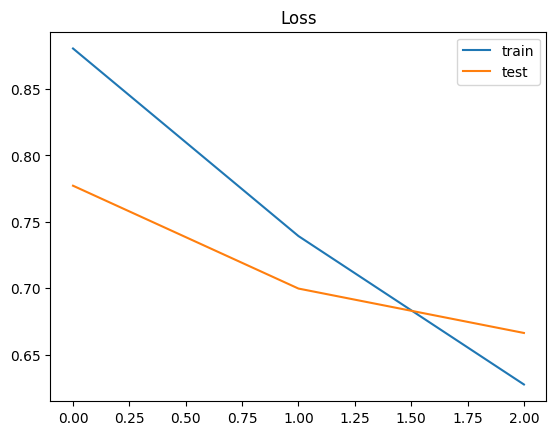

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

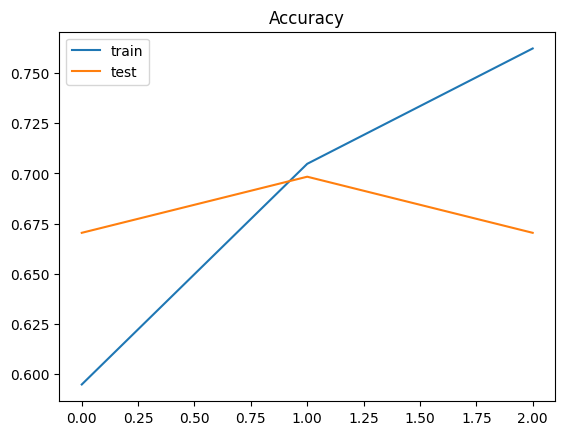

In [18]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# ==== MODEL PERFORMANCE WITH LOADED MODEL ====

# PREDICTION FUNCTION AND CLASSIFICATION REPORT

In [21]:
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
import numpy as np

# The maximum number of words to be used. (most frequent)
FREQUENT_WORDS_COUNT = 20000
# Max number of words for the padding -> max length tweet 280 chars ~60 words, also best results after experimenting
SEQUENCE_LENGTH_COUNT = 60

def prepare_tokenizer_new_input(frequent, train_data):
    tokenizer = Tokenizer(num_words=frequent, lower=True, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_data["Tweet"].values) 
    return tokenizer

def get_results(dataframe, model, tokenizer, column_name='Tweet'):
    # Ensure the column exists in the dataframe
    if column_name not in dataframe.columns:
        raise ValueError(f"Column {column_name} not found in the dataframe.")

    # Convert tweets to sequences and pad them
    sequences = tokenizer.texts_to_sequences(dataframe[column_name].values)
    padded_sequences = pad_sequences(sequences, maxlen=SEQUENCE_LENGTH_COUNT)

    # Get model predictions
    predictions = model.predict(padded_sequences)

    # Map predictions to sentiment labels
    labels = ['negative', 'neutral', 'positive']
    predicted_labels = [labels[np.argmax(pred)] for pred in predictions]

    # Generate classification report
    return classification_report(dataframe['Sentiment'].values, predicted_labels)


In [22]:
from tensorflow import keras
LOADED_ENG_LSTM_OOV = keras.models.load_model('/Users/Feli/Desktop/SEntiment/USE_ENG_LSTM_OOV')


In [29]:
# The maximum number of words to be used. (most frequent)
FREQUENT_WORDS_COUNT = 20000
# Max number of words for the padding -> max length tweet 280 chars ~60 words, also best results after experimenting
SEQUENCE_LENGTH_COUNT =60

tokenizer = prepare_tokenizer_new_input(FREQUENT_WORDS_COUNT, df)

In [23]:
# Example usage
tokenizer = prepare_tokenizer_new_input(FREQUENT_WORDS_COUNT, df)
report = get_results(dfi, LOADED_ENG_LSTM_OOV, tokenizer, column_name='Tweet')
print(report)

62/62 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

    negative       0.14      0.15      0.15       130
     neutral       0.69      0.88      0.77      1222
    positive       0.67      0.29      0.41       627

    accuracy                           0.65      1979
   macro avg       0.50      0.44      0.44      1979
weighted avg       0.65      0.65      0.62      1979



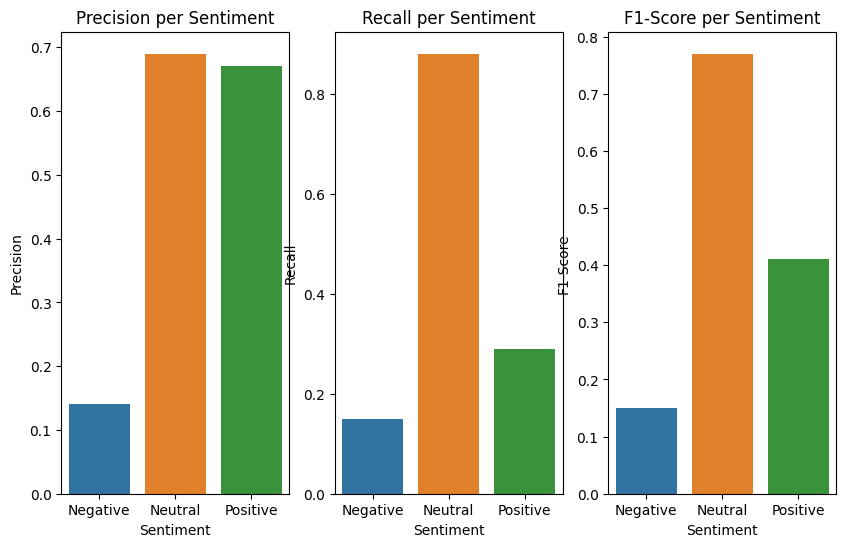

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for English LSTM model
data_english = {
    "Sentiment": ["Negative", "Neutral", "Positive"],
    "Precision": [0.14, 0.69, 0.67],
    "Recall": [0.15, 0.88, 0.29],
    "F1-Score": [0.15, 0.77, 0.41],
    "Support": [130, 1222, 627]
}

df_english = pd.DataFrame(data_english)

# Plotting
plt.figure(figsize=(10, 6))

# Precision, Recall, and F1-Score
plt.subplot(1, 3, 1)
sns.barplot(x="Sentiment", y="Precision", data=df_english)
plt.title("Precision per Sentiment")

plt.subplot(1, 3, 2)
sns.barplot(x="Sentiment", y="Recall", data=df_english)
plt.title("Recall per Sentiment")

plt.subplot(1, 3, 3)
sns.barplot(x="Sentiment", y="F1-Score", data=df_english)
plt.title("F1-Score per Sentiment")

# Save the figure
plt.savefig('english_lstm_performance.png', dpi=300)

# Show the plot
plt.show()
